## Between-group differences in effect prevalence versus in effect size

In [1]:
# if running from 'examples' directory of p2prev repo, 
# we need to add parent directory to module search path
# so that p2prev module can be imported
# (not necessary if you've pip installed p2prev module)
import sys
import os
cwd = os.getcwd()
pardir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(pardir)

# if you have p2prev installed, you can start with the next chunk:

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import binomtest
from matplotlib import pyplot as plt
import arviz as az
import os

from p2prev import PCurveMixture

np.random.seed(0)

We'll load the pitch-labelling accuracies from [Van Hedger et al.'s (2020)](https://doi.org/10.1371/journal.pone.0244308) study on the population distribution of pitch-labelling ability. Those who perform highest on this measure are said the have "absolute pitch" (AP) or often "perfect pitch", which is considered a rare perceptual skill. Most people, for instance, can recognize and name colors on sight, but very few people can reliably recognize/name a musical note without comparing it to a reference note, even among skilled musicians -- whereas relative pitch memory (i.e. remembering the relationship between notes) is more common.

Van Hedger et al. (2020) put up an online test where people could find out whether they have absolute pitch. The test ended up getting featured in a [Wall Street Journal article](https://www.wsj.com/articles/can-perfect-pitch-be-learned-1497178800?reflink=desktopwebshare_permalink), and so it ended up attracting a substanial number of participants (who presumably self-selected for believing they have some non-chance ability to name muscial notes).

The historicallly prevailing theoretic asusmption in the field is that AP is a dichotomous trait -- you either have it and perform near perfectly on pitch labelling tasks, or you don't have the trait at all. However, Van Hedger et al. (2020) used mixture modelling to argue that (1) the population distribution among this self-selected group consisted of an at-chance group and and above-chance group of participants, and (2) the mean of the above-chance group was less than perfect performance. In other words, those possessing "perfect pitch" are just the upper tail of a subset of the population has above-chance, but not necessarily perfect, absolute pitch memory. This population distribution, they say, is more indicative of a perceptual skill with grated levels of performance, rather than a dichotomous trait. 

Here, we'll extend their analysis. First, we'll replicate the characterization of the population distribution as a mixture of at- and above-chance participants using a $p$-curve mixture model. Then, we'll assess whether the higher rates of _observed_ AP ability in tonal language speakers, commonly described as a population prevalence difference in the liaterature (i.e. tonal language speakers are more likely to show the dichotomous trait), is better accounted for by an actual prevalence difference or a difference in within-subject effect size (and thus, detectability).

In [3]:
# this CSV can be obtained from https://osf.io/v46aj (DOI 10.17605/OSF.IO/V46AJ)
csv_fpath = os.path.join('resources', 'apsummarydata.csv')
df = pd.read_csv(csv_fpath)
df[['ACC', 'Tonal']].head()

,ACC,Tonal
0,0.833333,0
1,0.104167,0
2,0.937500,1
3,0.083333,0
4,0.187500,1


In [4]:
# convert accuracies to number correct 
n_trials = 48 # see Methods in Van Hedger et al. (2020) 
chance = 4 / 48 # probability of correct if guessing
accuracy = df.ACC.to_numpy()
ks = np.round(accuracy * n_trials).astype(int)
# and compute within-subject p-values using the binomial test
pvals = [binomtest(k, n_trials, chance, alternative = 'greater').pvalue for k in ks]
pvals = np.array(pvals)
pvals[pvals == 1] = 1 - 1e-6 # for numerics, since P[p-value = 1] = 0 for most tests

In [5]:
# fit model on full sample to estimate prevalence of above-chance 
# pitch-labelling accuracy (H1) in the sampled population
model = PCurveMixture(pvals)
model.fit()
model.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 30 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
effect_size,11.573,0.127,11.341,11.821,0.002,0.001,5183.0,3590.0,1.0
prevalence,0.533,0.040,0.458,0.607,0.001,0.000,5157.0,3641.0,1.0


We estimate a prevalence between 45% and 60% in the sampled population. But keep in mind: the sampled population isn't "the" population, it's a population that's already self-selected for high pitch-labelling ability.

A useful feature of $p$-curve mixtures is that they can be applied to any data for which you can compute a within-subject $p$-value, but the tradeoff is that the "effect size" in the results above is abstract, rather than in the original units of the data. This means that the effect size "estimate" we see above is only interpretable on a relative scale, such as between two groups where all subjects were subjected to the same within-subject test. We will do such a between-group comparison later in this tutorial. 

> **Note:** If you want to put the effect size estimate on a more interpretable scale, you can convert the within-subject effect size estimate to within-subject power at some significance level $\alpha$ of your choice, as in the `prevalence-estimation.ipynb` tutorial notebook.

In [6]:
# we can also fit alternative (i.e. H1 only or H0 only) 
# models and apply Bayesian model comparison to see 
# which our data are most consistent with
model.fit_alternative()
model.compare()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 15 seconds.


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mixture,0,5328.117782,11.769203,0.000000,0.772750,512.331640,0.000000,False,log
all $H_1$,1,2998.040580,38.108437,2330.077202,0.165393,481.998423,181.911924,False,log
all $H_0$,2,0.000000,0.000000,5328.117782,0.061857,0.000000,512.331640,False,log


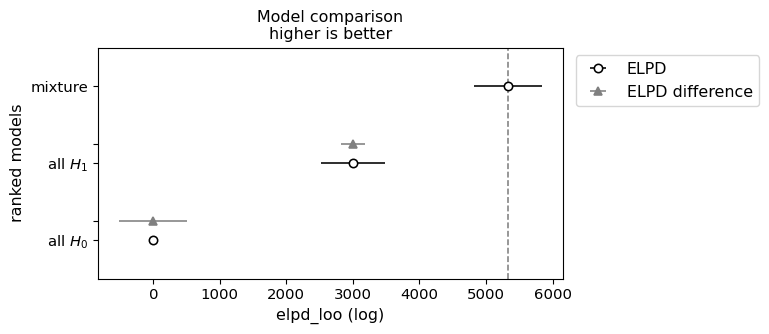

In [7]:
model.plot_compare()
plt.show()

As shown above, evidence for a mixture of above-chance and at-chance performers is very strong. This is consistent with both the "perfect pitch" view where AP is a dichotomous trait and the grated skill view, since both would posit that a large group of subjects should be at-chance. Where these views differ is how the above-chance folks are distributed -- are all above-chance performers at the same, near perfect level of performance, or is there measingful variation in performance within this group?

Our next analysis will get at that question. It is a common finding in the literature that speakers of tonal languages have higher rates of _observed_ AP than those who don't speak a tonal language, but _observed_ AP is normally operationalized as sample accuracy on a pitch-labelling task exceeding some threshold. Another possibility is that the prevalence of AP does not differ in tonal language speakers, but the _within-subject effect size_ (i.e. accuracy given they are above-chance AP performers), which directly determines the probability that their sample accuracy will exceed whatever threshold. In other words, the difference between tonal and non-tonal language speaking groups may be in the _detectability_ of AP, rather than its prevalence -- which is only a possibility if AP is a grated skill, where the within-subject effect size can vary between above-chance subjects. 

If we assume the effect of group is fixed (and it is normally reasonable to believe that measurements from seperate groups of subjects are independent of one another) then we can simply fit $p$-curve mixture models to each group seperately and compare posterior distributions between models.
> **Note:** This independence assumption can be violated, for instance, if you are trying to assess the relative prevalence of two _different_ effects in the _same_ group of subjects (e.g. maybe you've assessed both absolute pitch accuracy and relative pitch accuracy), or if you have tested subjects for the same effect in two experimental conditions (e.g. sine tone stimuli in one condition and piano tones in the other). Then, you have to account for the possibility that a subject expresses one effect is is more or less likely to also express the other. In that case, you shouldn't fit models seperately to each condition as we do below with `p2prev.PCurveMixture` but instead fit a combined model with `p2prev.PCurveWithinGroupDifference`.

In [9]:
# fit models to tonal language speakers and others seperately 
model_tonal = PCurveMixture(pvals[df.Tonal == 1])
model_tonal.fit()
model_nontonal = PCurveMixture(pvals[df.Tonal == 0])
model_nontonal.fit()

# subtract posterior samples to get posterior samples for difference
# (this is valid when we assume the effect of group is fixed
hdip = 0.95
hdi_prev = az.hdi(model_tonal.prevalence - model_nontonal.prevalence, hdi_prob = hdip)
hdi_eff = az.hdi(model_tonal.effect_size - model_nontonal.effect_size, hdi_prob = hdip)
# and report 95% highest-density intervals (HDIs)
print('\n\n%.01f%% highest-density intervals (compare to 0.0):\n'%(100*hdip))
print('HDI for prevalence increase in tonal-speaking population:', hdi_prev)
print('HDI for within-subject effect size increase:', hdi_eff, '\n')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [effect_size, prevalence]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 21 seconds.




95.0% highest-density intervals (compare to 0.0):

HDI for prevalence increase in tonal-speaking population: [-0.01881103  0.35139594]
HDI for within-subject effect size increase: [0.18191103 1.21699305] 



Here, we see strong evidence that the within-subject effect size (i.e. pitch-labelling accuracy) and thus within-subject power is higher among tonal language speakers, given that they have above-chance AP performance. Conversely, we see relatively weaker (though still not negligible) evidence that the population prevalence is increased in tonal language speakers. This is very different from the common interpretation of tonal language effects on AP in the literature.  

This example illustrates that a difference in the rate at which an effect is _detected_ between two groups/conditions does not _automatically_ equate to an actual difference in prevalence. One also has to consider the possibility that the effect is more _detectable_ in one group/condition than in the other (i.e. a difference in within-subject effect size). Methods for estimating population prevalence from within-subject statistics, but [assume fixed within-subject power](https://doi.org/10.7554/eLife.62461), cannot be used to differentiate these possibilities. While ad hoc/custom Bayesian mixture modelling can be used to do so, these models often have to be implemented from scratch, representing a high barrier to entry for most practicing researchers; $p$-curve mixture models are meant to democratize the use of mixture modelling so that they can be used by non-experts.